In [1]:
git_repo = '../../../../'

import sys
import os
import glob

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib
import LinearResponseVariationalBayes.ModelSensitivity as model_sens

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json

# Load original model

In [2]:
fit_dir = './iris_fits_for_nips/'

In [18]:
json_input_file = os.path.join(fit_dir, 'bnp_full_data_fit_alpha3.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)
    prior_param_vec0 = model.prior_params.get_vector()
    
#moment_model = gmm_utils.InterestingMoments(model)


In [19]:
alpha0 = model.prior_params['alpha'].get()
print(alpha0)

[3.]


# Set up linear sensitivity class

In [20]:
# this is analagous to the moment model, but for expected number of clusters
# e_num_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
# e_num_clusters_class.set_e_num_clusters_from_free_param(best_param)

# linear_sensitivity = \
#     obj_lib.ParametricSensitivity(\
#         objective_fun =             model.set_z_get_kl,\
#         input_par =                 model.global_vb_params,\
#         output_par =                e_num_clusters_class.e_num_clusters,\
#         hyper_par =                 model.prior_params,\
#         input_to_output_converter = e_num_clusters_class.set_e_num_clusters,\
#         optimal_input_par =         best_param,\
#         objective_hessian =         kl_hessian)


linear_sensitivity = \
    model_sens.ParametricSensitivityLinearApproximation(\
        objective_functor =         model.set_z_get_kl,\
        input_par =                 model.global_vb_params,\
        hyper_par =                 model.prior_params,\
        input_val0 = best_param, 
        hyper_val0 = prior_param_vec0, 
        hess0 = kl_hessian)


# Load refitted models and get linear approximations 

In [21]:
# # Get the expected posterior predictive number of distinct clusters.
# def get_e_num_pred_clusters_from_free_par(free_par, model):
#     model.global_vb_params.set_free(free_par)
#     mu = model.global_vb_params['v_sticks']['mean'].get()
#     sigma = 1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get())
#     n_obs = model.n_obs
#     return modeling_lib.get_e_number_clusters_from_logit_sticks(mu, sigma, n_obs)

# # Get the expected posterior number of distinct clusters.
# def get_e_num_clusters_from_free_par(free_par, model):
#     model.global_vb_params.set_free(free_par)
#     model.set_optimal_z()
#     return modeling_lib.get_e_number_clusters_from_ez(model.e_z)

In [22]:
files = glob.glob(fit_dir +  '/bnp_full_data_fit_alpha*_iris.json')

In [23]:
e_num_heavy_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
e_num_pred_heavy_clusters_class = gmm_utils.ExpectedPredNumClusters(model)

In [24]:
threshold = 0

In [25]:
free_par_refit_list = []
free_par_lr_list = []

e_num_clusters_lr_list = []
e_num_clusters_refit_list = []

e_num_pred_clusters_lr_list = []
e_num_pred_clusters_refit_list = []

alpha_vec = np.zeros(len(files))

for i in range(len(files)):
    print(files[i])
    
    # load perturbed model 
    #json_input_file = os.path.join(fit_dir, files[i])
    json_input_file = os.path.join(files[i])

    with open(json_input_file, 'r') as fp:
        fit_dict = json.load(fp)
        model_refit = gmm_utils.get_model_from_checkpoint(fit_dict)
    
    # prior parameters from refitted model
    alpha_vec[i] = model_refit.prior_params['alpha'].get()
    prior_param_vec_pert = model_refit.prior_params.get_vector() 

    # get free parameters from the refitted model 
    free_par_refit = model_refit.global_vb_params.get_free()
    free_par_refit_list.append(free_par_refit)
    
    # linear approximation for free params
    free_par_lr = linear_sensitivity.predict_input_par_from_hyperparameters(
        prior_param_vec_pert) 
    free_par_lr_list.append(free_par_lr)
    
    # linear approximation for num clusters
    #out_par_lr = linear_sensitivity.predict_output_par_from_hyperparameters(prior_param_vec_pert, linear = False)
#     e_num_pred_clusters_lr_list.append(
#         gmm_utils.get_e_num_pred_clusters_from_free_par(
#             free_par_lr, model_refit))
#     e_num_pred_clusters_refit_list.append(
#         gmm_utils.get_e_num_pred_clusters_from_free_par(
#             free_par_refit, model_refit))

#     e_num_clusters_lr_list.append(
#         gmm_utils.get_e_num_clusters_from_free_par(
#             free_par_lr, model_refit))
#     e_num_clusters_refit_list.append(
#         gmm_utils.get_e_num_clusters_from_free_par(
#             free_par_refit, model_refit))

    e_num_pred_clusters_lr_list.append(
        e_num_pred_heavy_clusters_class.get_e_num_pred_heavy_clusters_from_free_par(
            free_par_lr, threshold = threshold))
    e_num_pred_clusters_refit_list.append(
        e_num_pred_heavy_clusters_class.get_e_num_pred_heavy_clusters_from_free_par(
            free_par_refit, threshold = threshold))

    e_num_clusters_lr_list.append(
        e_num_heavy_clusters_class.get_e_num_heavy_clusters_from_free_par(
            free_par_lr, threshold = threshold)[0])
    e_num_clusters_refit_list.append(
        e_num_heavy_clusters_class.get_e_num_heavy_clusters_from_free_par(
            free_par_refit, threshold = threshold)[0])

    #out_par_lr_list.append(out_par_lr)
    
    # refitted num clusters
    #model_refit.set_optimal_z()
    #out_par_refit = modeling_lib.get_e_number_clusters_from_ez(model_refit.e_z)
    #out_par_refit = modeling_lib.get_e_number_clusters_from_logit_sticks(model_refit)
    #out_par_refit_list.append(out_par_refit)


./iris_fits_for_nips/bnp_full_data_fit_alpha9.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha1.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha15.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha13.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha12.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha0.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha5.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha12.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha7.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha3.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha5.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha10.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha2.0_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha14.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha8.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json
./iris_fits_for_nips/bnp_full_data_fit_alpha7.5_iris.json
./iris_f

### Check the free parameters

In [26]:
# for i in range(len(free_par_refit_list)): 
#     plt.figure()
#     plt.plot(free_par_lr_list[i]- best_param, free_par_refit_list[i] - best_param, '+')
#     plt.plot(free_par_lr_list[i]- best_param, free_par_lr_list[i]- best_param, '-')
#     plt.title('alpha = {}'.format(alpha_vec[i]))

In [27]:
model.global_vb_params.set_free(best_param)
model.set_optimal_z()

print(np.sum(model.e_z, axis=0) / model.n_obs)
print(gmm_utils.get_e_num_clusters_from_free_par(best_param, model_refit))

e_z = model.e_z
k = np.shape(e_z)[1]
print(k - np.sum(np.prod(1 - e_z, axis = 0)))

print(k)
print(np.prod(1 - e_z, axis = 0).shape)

[3.33333268e-01 3.11440402e-01 2.77215414e-01 2.14232749e-03
 4.08355666e-03 6.31707577e-02 5.49646957e-03 1.27791625e-03
 7.67222549e-04 4.41027531e-04 2.46600538e-04 1.39324975e-04
 8.35413887e-05 5.26483603e-05 3.43568333e-05 2.29817563e-05
 1.56452130e-05 1.07839319e-05 7.49866701e-06 5.24664557e-06
 3.68706144e-06 2.59910250e-06 1.83619209e-06 1.29923302e-06
 9.20309635e-07 6.52408942e-07 4.62749958e-07 3.28354972e-07
 2.33056920e-07 9.90627098e-07]
5.979554531850777
5.979554531850777
30
(30,)


# Plot results on expected number of clusters

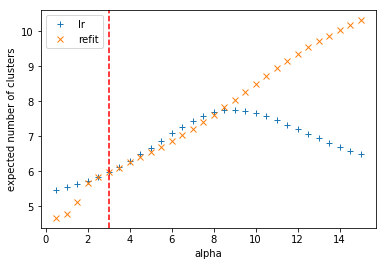

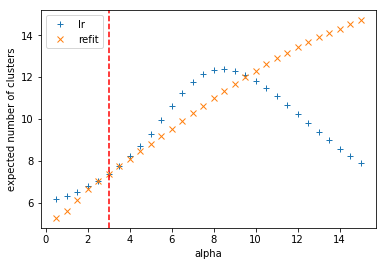

In [28]:
plt.plot(alpha_vec, e_num_clusters_lr_list, '+')
plt.plot(alpha_vec, e_num_clusters_refit_list, 'x')

plt.axvline(x=alpha0, linestyle = '--', color = 'red')

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')

plt.legend(('lr', 'refit'))

plt.figure()
plt.plot(alpha_vec, e_num_pred_clusters_lr_list, '+')
plt.plot(alpha_vec, e_num_pred_clusters_refit_list, 'x')

plt.axvline(x=alpha0, linestyle = '--', color = 'red')

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')

plt.legend(('lr', 'refit'))

In [29]:
print('Done.')

Done.


In [30]:
alpha0_ = int(alpha0)

In [31]:
e_num_clust_results = np.array([alpha_vec, 
                                   np.array(e_num_clusters_refit_list).squeeze(), 
                                   np.array(e_num_clusters_lr_list).squeeze()])

np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/' + 
           'param_sens_init_alpha{}_thresh{}_e_num_clusters.csv'.format(alpha0_, threshold), 
        e_num_clust_results, 
          delimiter = ',')

In [32]:
e_num_clust_pred_results = np.array([alpha_vec, 
                                   np.array(e_num_pred_clusters_refit_list).squeeze(), 
                                   np.array(e_num_pred_clusters_lr_list).squeeze()])

np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/' + 
           'param_sens_init_alpha{}_thresh{}_e_num_clusters_pred.csv'.format(alpha0_, threshold), 
        e_num_clust_pred_results, 
          delimiter = ',')